# 1. Gather Data

In [54]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [55]:
data_path = '/home/kshitij/Documents/dataScience/textClassification_IMDB/sentiment_analysis/'

In [56]:
seed = 123

In [57]:
imdb_data_path = os.path.join(data_path, 'aclImdb')

In [58]:
imdb_data_path

'/home/kshitij/Documents/dataScience/textClassification_IMDB/sentiment_analysis/aclImdb'

## Training set

In [60]:
# Load the training data
train_texts = []
train_labels = []
for category in ['pos', 'neg']:
    train_path = os.path.join(imdb_data_path, 'train', category)
    for fname in sorted(os.listdir(train_path)):
        if fname.endswith('.txt'):
            with open(os.path.join(train_path, fname)) as f:
                train_texts.append(f.read())
            train_labels.append(0 if category == 'neg' else 1)


## Test/Validation set

In [61]:
test_texts = []
test_labels = []
for category in ['pos', 'neg']:
    test_path = os.path.join(imdb_data_path, 'test', category)
    for fname in sorted(os.listdir(test_path)):
        if fname.endswith('.txt'):
            with open(os.path.join(test_path, fname)) as f:
                test_texts.append(f.read())
            test_labels.append(0 if category == 'neg' else 1)

In [62]:
# Shuffle the training data and labels. T
random.seed(seed)
random.shuffle(train_texts)
random.seed(seed)
random.shuffle(train_labels)

In [66]:
np.array(train_labels)

array([0, 0, 1, ..., 1, 1, 1])

In [67]:
np.array(test_labels)

array([1, 1, 1, ..., 0, 0, 0])

# 2. Explore the data

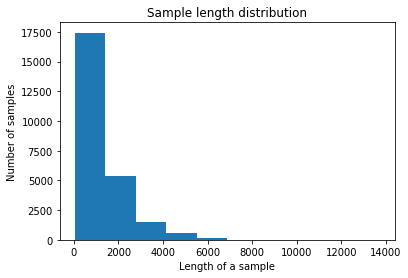

In [68]:
plt.hist([len(s) for s in train_texts])
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

# 3. Prepare your data

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [70]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [71]:
kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }

In [72]:
vectorizer = TfidfVectorizer(**kwargs)


In [73]:
# Learn vocabulary from training texts and vectorize training texts.
x_train = vectorizer.fit_transform(train_texts)


/home/kshitij/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1569: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [74]:
# Vectorize validation texts.
#x_val = vectorizer.transform(val_texts)


In [75]:
print(x_train[0])

  (0, 436686)	0.02919573530225501
  (0, 436415)	0.035663496901798576
  (0, 436097)	0.01982615441258547
  (0, 428593)	0.029185442353921075
  (0, 427126)	0.06187935126620944
  (0, 426772)	0.0167661351978179
  (0, 426691)	0.041391480358561175
  (0, 426688)	0.035320596405992964
  (0, 423999)	0.020038349175493447
  (0, 423694)	0.18031252260348699
  (0, 422809)	0.04417636967508156
  (0, 420797)	0.026808134056327485
  (0, 420226)	0.012451823342025409
  (0, 420184)	0.0551002311020587
  (0, 420151)	0.033300196830641955
  (0, 420030)	0.028560034514764403
  (0, 419410)	0.01186208607902722
  (0, 418909)	0.031445397743511565
  (0, 418105)	0.014228366646665264
  (0, 416036)	0.03661470233861506
  (0, 415760)	0.014939126889031937
  (0, 415409)	0.028923680189604443
  (0, 415299)	0.01774379968552041
  (0, 415084)	0.025165549567980214
  (0, 414830)	0.015548854693674567
  :	:
  (0, 22081)	0.04788016474730238
  (0, 21141)	0.03104344779139404
  (0, 19073)	0.06187935126620944
  (0, 18752)	0.06380487120022792

In [76]:
x_train.shape

(25000, 438613)

In [77]:
# Select top 'k' of the vectorized features. #20k
selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
selector.fit(x_train, train_labels)
x_train = selector.transform(x_train).astype('float32')

In [78]:
x_train.shape #top 20k features , where = how much each token contributes to label prediction

(25000, 20000)

# 4. Build, Train and Evaluate

In [41]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [42]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [43]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimetrnsion of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [49]:
train_texts[0]

"POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. International Man of Mystery came straight out of the blue. It was a lone star that few people had heard of. But it was stunningly original, had sophisticated humour and ample humour, always kept in good taste, and had a brilliant cast. The Spy Who Shagged Me was a lot more commercially advertised and hyped about.<br /><br />OK I'll admit, the first time I saw this film I thought it was very funny, but it's only after watching it two or three times that you see all the flaws. The acting was OK, but Heather Graham cannot act. Her performance didn't seem very convincing and she wasn't near as good as Liz Hurley was in the first one. Those characters who bloomed in the first one, (Scott Evil, Number 2 etc.) are thrown into the background hear and don't get many stand-alone scenes. The film is simply overrun with cameos.<br /><br />In particular, I hated the way they totally disregarded some o

In [52]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = explore_data.get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = vectorize_data.ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = build_model.mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [ ]:
results = train_ngram_model(x_train,)

In [ ]:
(train_texts, train_labels), (val_texts, val_labels) = data